In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
import scipy.stats as stats
%matplotlib inline

The amount of information is going to be less as the position in the hierarchy increases. And the amount of trust could be random throughout the network.

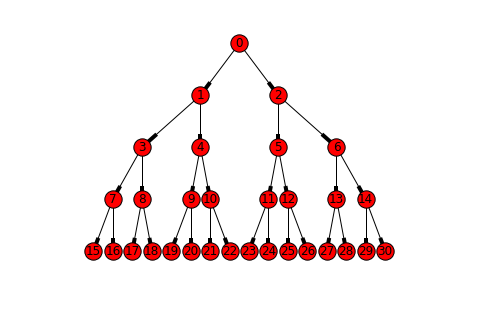

In [2]:
num_levels = 5
num_subordinates = 2
G = nx.DiGraph()
G.add_node(0)

leaf_nodes_last_level = [0]
nodes_in_levels = defaultdict(list)
nodes_in_levels[0] = [0]
levels_of_nodes = dict()
levels_of_nodes[0] = 0

for i in range(1, num_levels):
    #print i, pow(2,i)
    num_nodes_this_level = pow(2,i)
    possible_subordinates = range(G.number_of_nodes(), G.number_of_nodes()+ num_nodes_this_level )
    leaf_nodes_next_level = list(possible_subordinates)
    #print "possible subordinates", possible_subordinates

    while len(leaf_nodes_last_level) > 0:
        current_supervisor = leaf_nodes_last_level.pop(0)
        #print "after popping", leaf_nodes_last_level
        #print "##current supervisor", current_supervisor
        for j in range(num_subordinates):
            current_subordinate = possible_subordinates.pop(0)
            #print "####current subordinate", current_subordinate
            G.add_edge(current_supervisor, current_subordinate)
            #print "i", i
            nodes_in_levels[i].append(current_subordinate)
            levels_of_nodes[current_subordinate] = i
    leaf_nodes_last_level = list(leaf_nodes_next_level)
        
# pos = hierarchy_pos(btree2, 0)
#nx.draw(btree2,pos=nx.draw_networkx(btree2),with_labels=True,arrows=True)
pos=nx.nx_pydot.graphviz_layout(G,prog='dot')
nx.draw(G,pos,with_labels=True,arrows=True)

Our first assumption is that the deeper the level the less the initial information $H$ in the node. And we will distribute the initial $\alpha$ value distributed randomly using a lognormal distributions with parameter $\mu$ and $\sigma$

In [3]:
def sample_h(level, mean_info = 0.7, sd_info = 0.05, dmu = 0.1, constant = False):
    if constant == False:
        ## the distribution will be Truncated between 0 and 1
        lower, upper = 0, 1
        ## The distribution
        mu = mean_info - (dmu * (level-1))
        sigma = sd_info
        X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        s = X.rvs(1)[0]
        return s
    else:
        return mean_info

def sample_alpha(mu = 0.5, sigma = 0.1, constant = False):
    if constant == False:
        ## the distribution will be Truncated between 0 and 1
        lower, upper = 0, 1
        ## The distribution
        X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        s = X.rvs(1)[0]
        return s
    else:
        return mu

def sample_change_in_alpha(mu = 0.1, sigma = 0.01, constant = False):
    if constant == False:
        ## the distribution will be Truncated between 0 and 1
        lower, upper = 0, 1
        ## The distribution
        X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        s = X.rvs(1)[0]
        return s
    else:
        return mu

We do not have any problem assigning H in node 0 as there is no edge pointing towards him. So for mu, dmu * (level -1 ) is not a problem.

In [4]:
mean_trust = 0.2
sd_trust = 0.1
mean_info_higehst_level = 0.3
dmu_each_level = mean_info_higehst_level / (num_levels - 1)
mean_change_in_alpha = 0.05
sd_change_in_alpha = 0.001

for edge in G.edges():
    subordinate_node = edge[1]
    current_h = 0.2#sample_h(levels_of_nodes[subordinate_node], mean_info = mean_info_higehst_level, dmu = dmu_each_level)
    current_alpha = 0.5#sample_alpha(mean_trust, sd_trust)
    G[edge[0]][edge[1]]['H'] = current_h
    G[edge[0]][edge[1]]['alpha'] = current_alpha
    

In [5]:
nx.get_edge_attributes(G, 'alpha')

{(0, 1): 0.5,
 (0, 2): 0.5,
 (1, 3): 0.5,
 (1, 4): 0.5,
 (2, 5): 0.5,
 (2, 6): 0.5,
 (3, 7): 0.5,
 (3, 8): 0.5,
 (4, 9): 0.5,
 (4, 10): 0.5,
 (5, 11): 0.5,
 (5, 12): 0.5,
 (6, 13): 0.5,
 (6, 14): 0.5,
 (7, 15): 0.5,
 (7, 16): 0.5,
 (8, 17): 0.5,
 (8, 18): 0.5,
 (9, 19): 0.5,
 (9, 20): 0.5,
 (10, 21): 0.5,
 (10, 22): 0.5,
 (11, 23): 0.5,
 (11, 24): 0.5,
 (12, 25): 0.5,
 (12, 26): 0.5,
 (13, 27): 0.5,
 (13, 28): 0.5,
 (14, 29): 0.5,
 (14, 30): 0.5}

In [6]:
nx.get_edge_attributes(G, 'H')

{(0, 1): 0.2,
 (0, 2): 0.2,
 (1, 3): 0.2,
 (1, 4): 0.2,
 (2, 5): 0.2,
 (2, 6): 0.2,
 (3, 7): 0.2,
 (3, 8): 0.2,
 (4, 9): 0.2,
 (4, 10): 0.2,
 (5, 11): 0.2,
 (5, 12): 0.2,
 (6, 13): 0.2,
 (6, 14): 0.2,
 (7, 15): 0.2,
 (7, 16): 0.2,
 (8, 17): 0.2,
 (8, 18): 0.2,
 (9, 19): 0.2,
 (9, 20): 0.2,
 (10, 21): 0.2,
 (10, 22): 0.2,
 (11, 23): 0.2,
 (11, 24): 0.2,
 (12, 25): 0.2,
 (12, 26): 0.2,
 (13, 27): 0.2,
 (13, 28): 0.2,
 (14, 29): 0.2,
 (14, 30): 0.2}

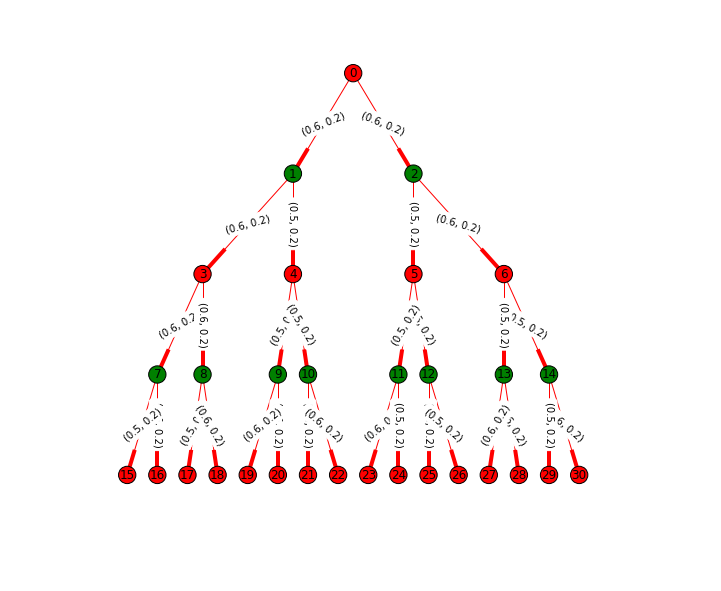

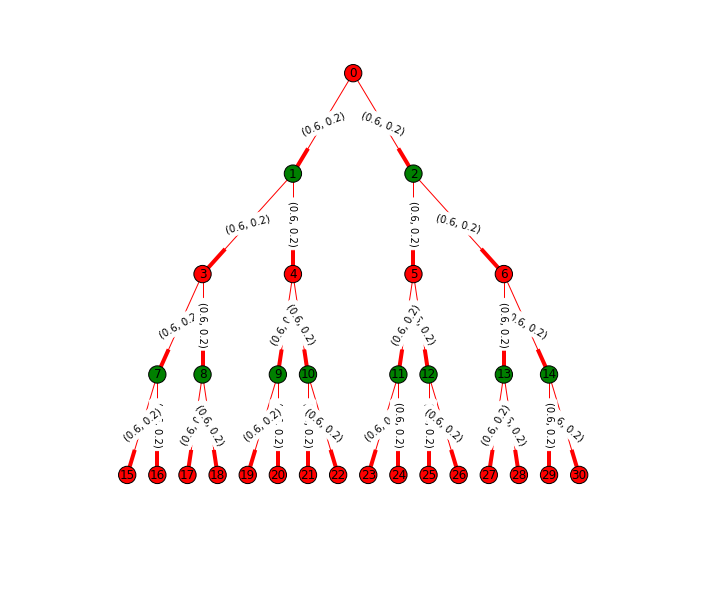

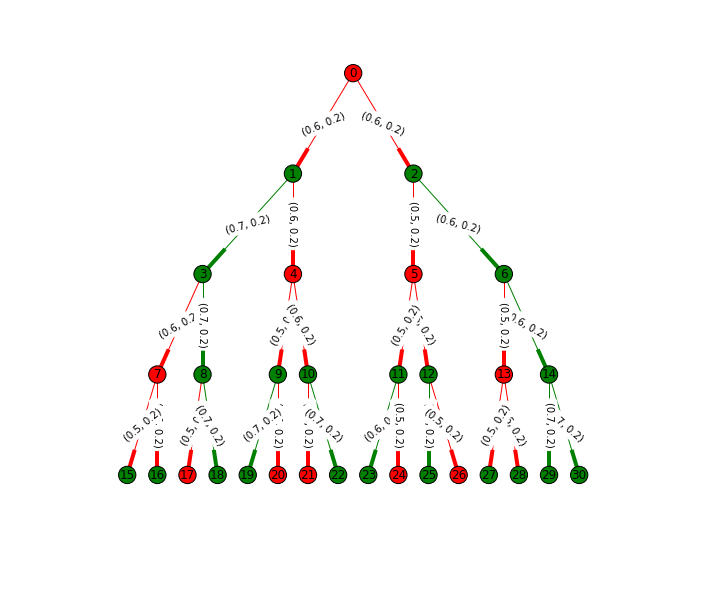

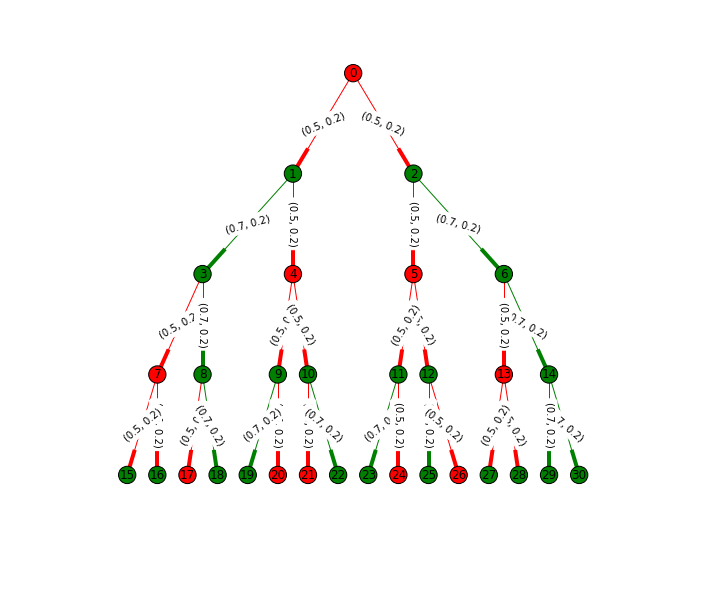

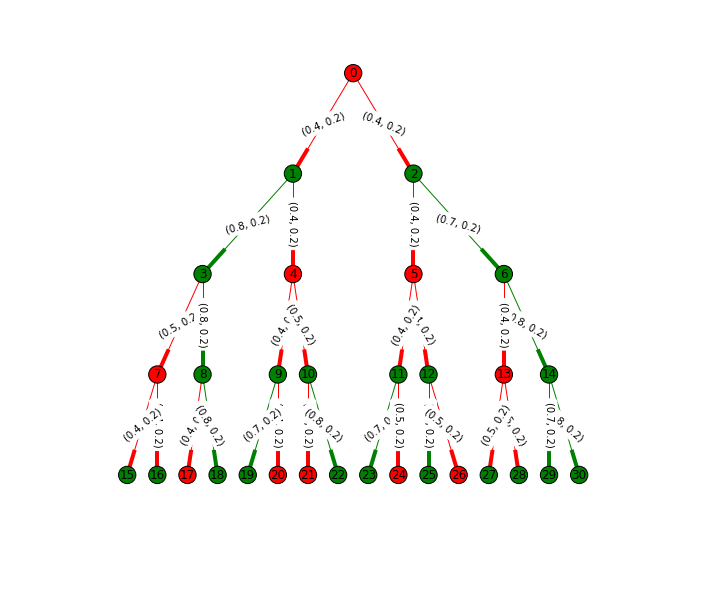

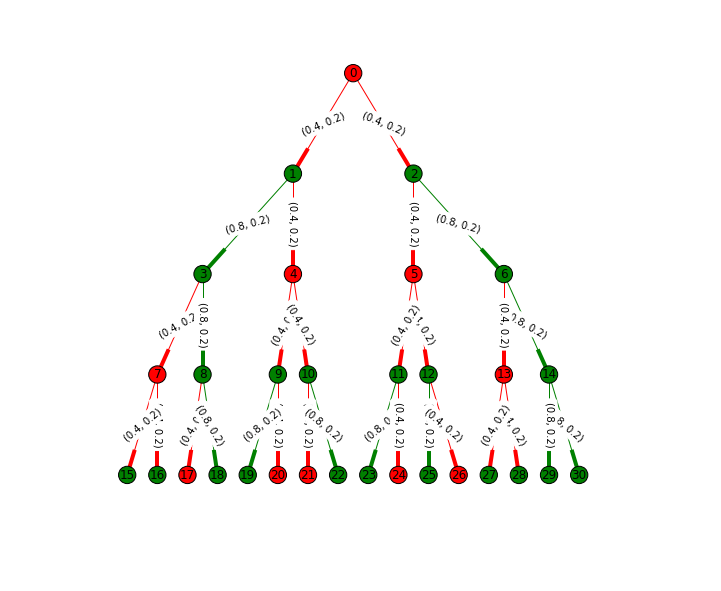

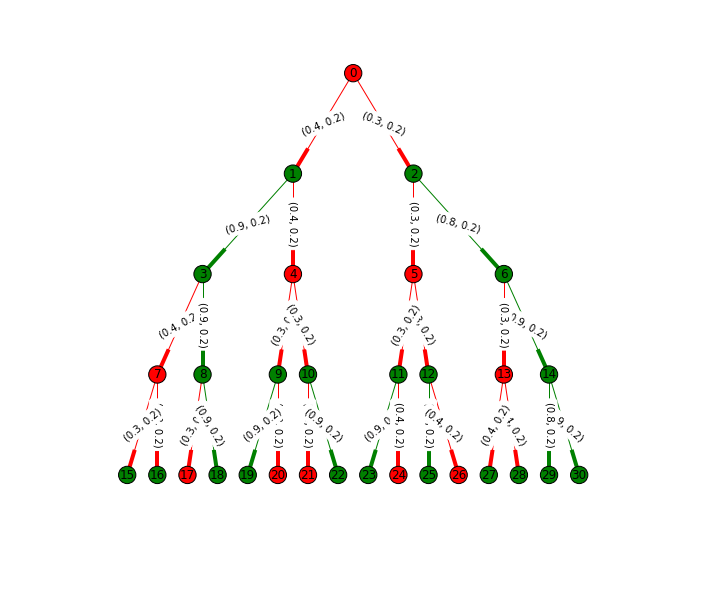

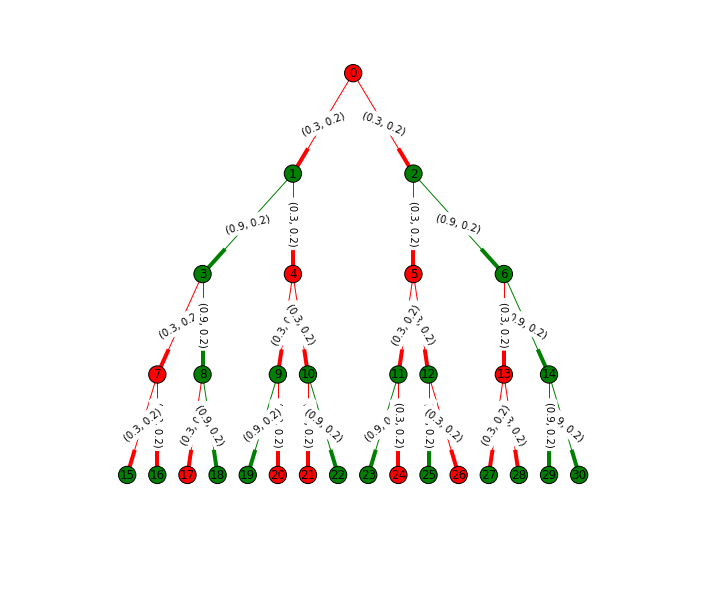

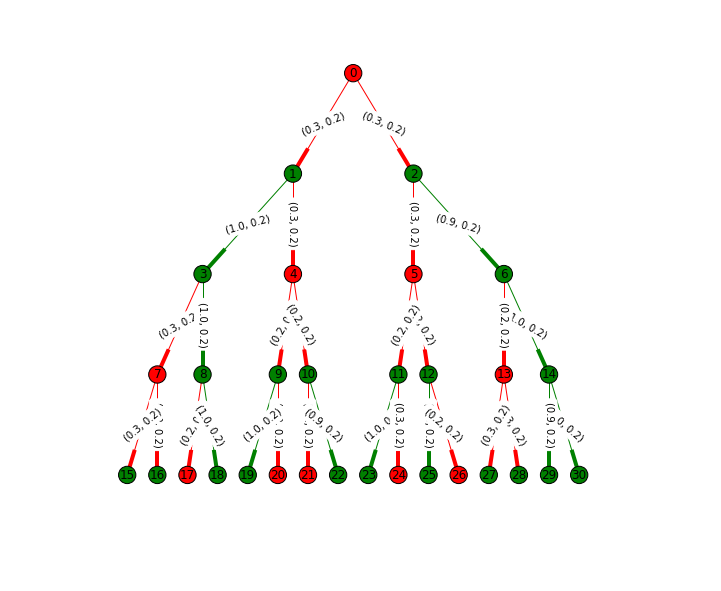

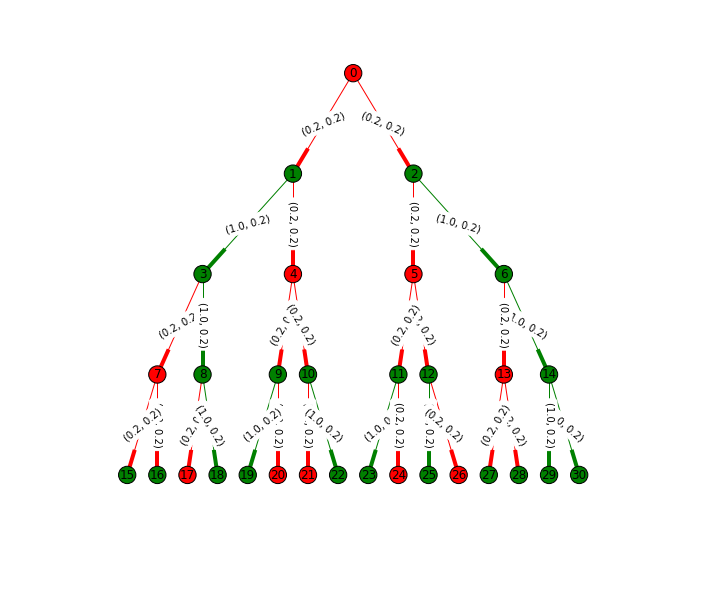

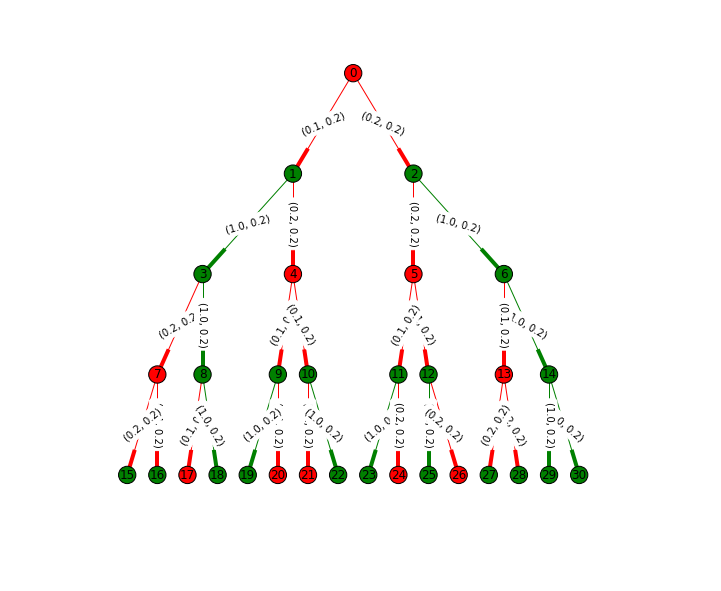

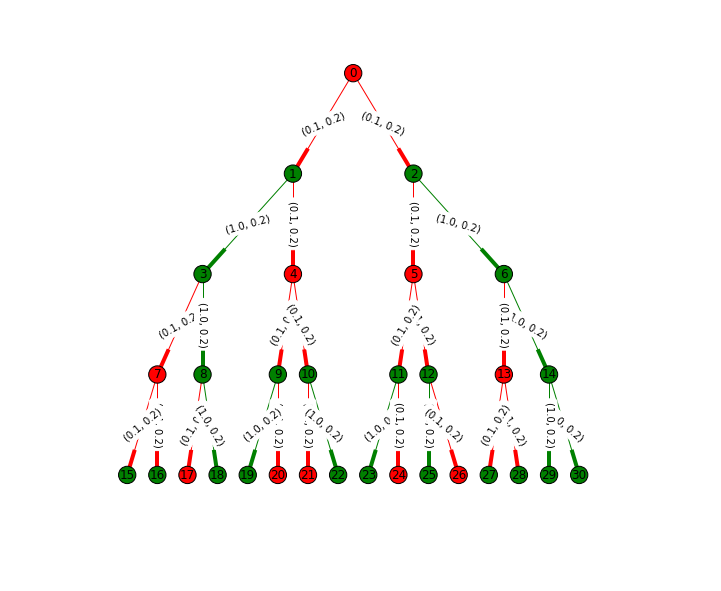

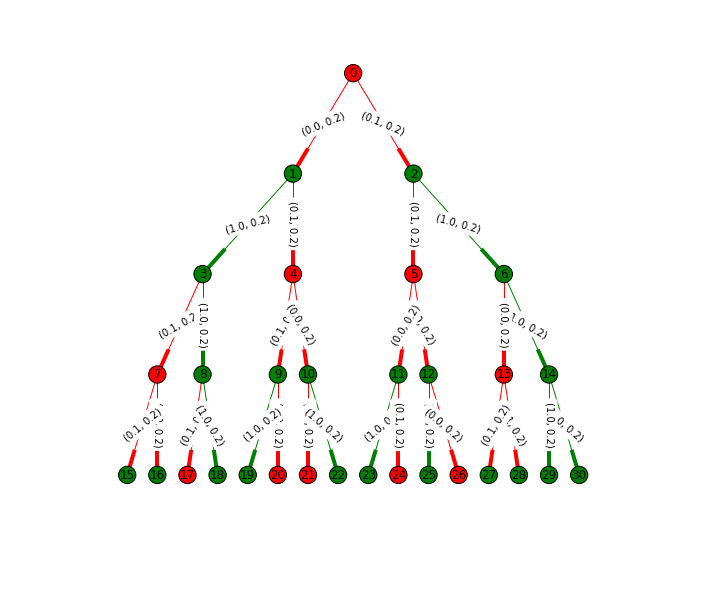

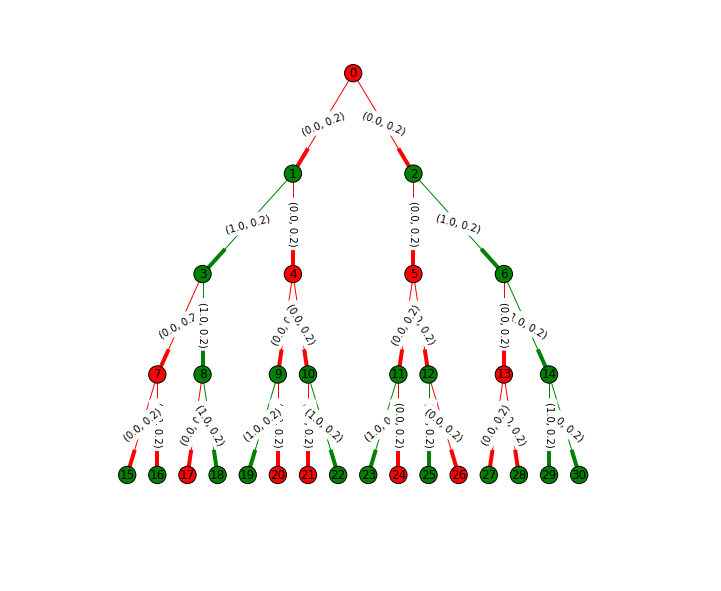

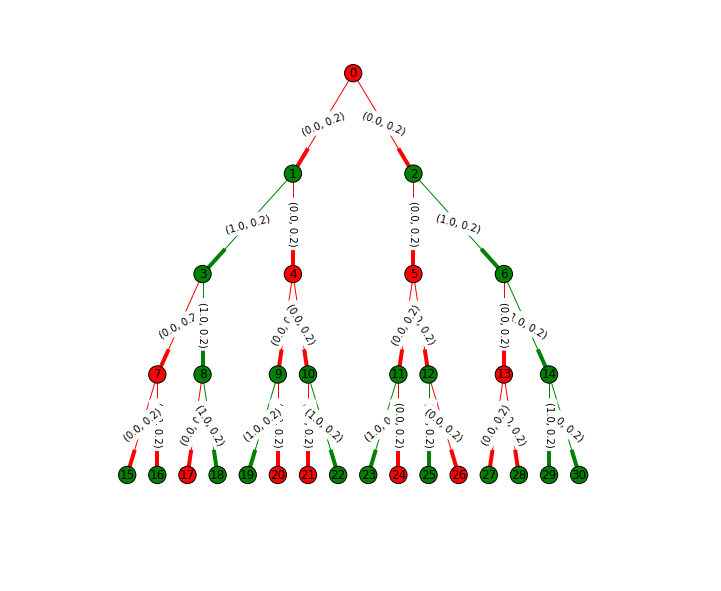

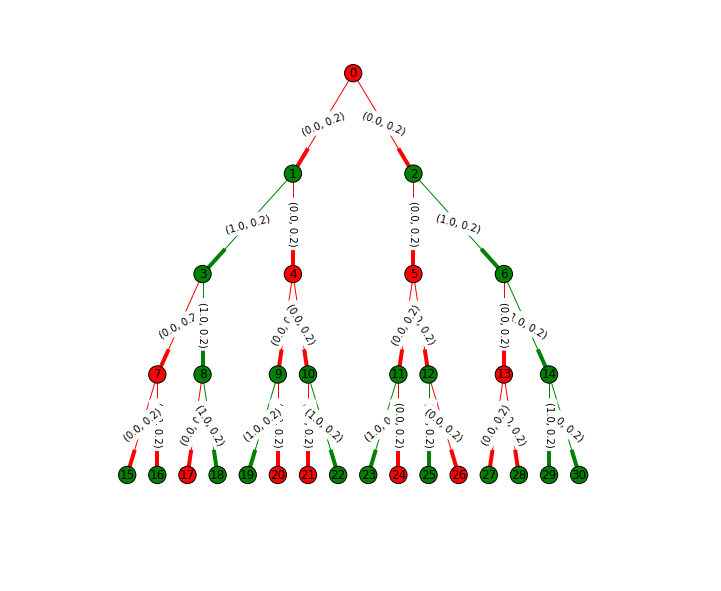

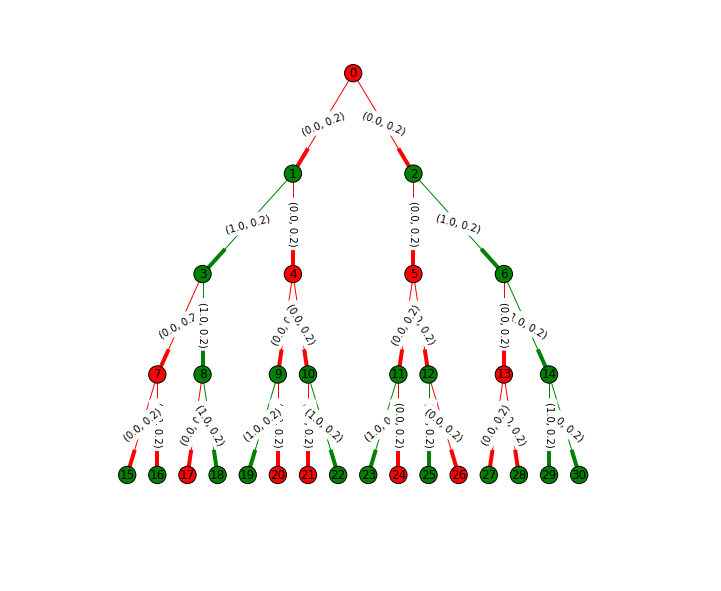

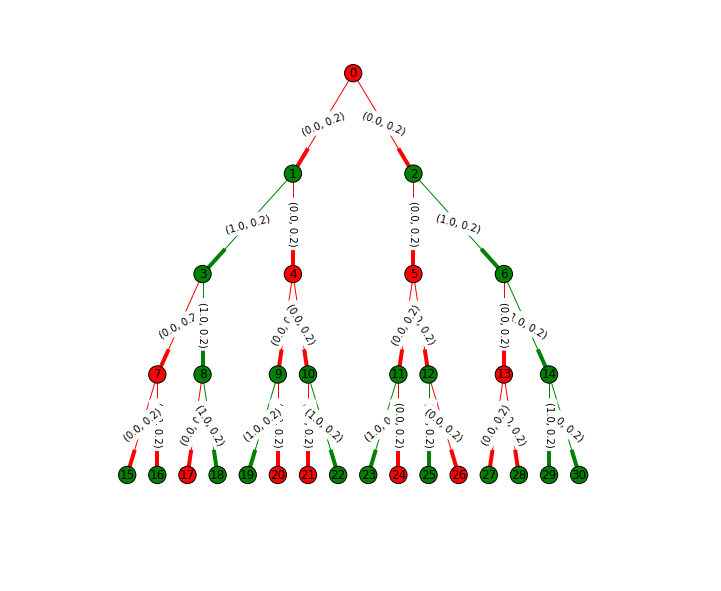

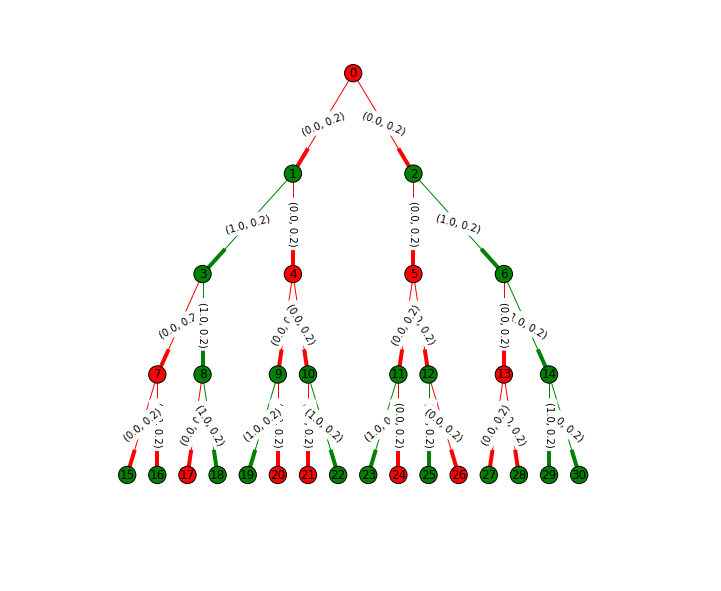

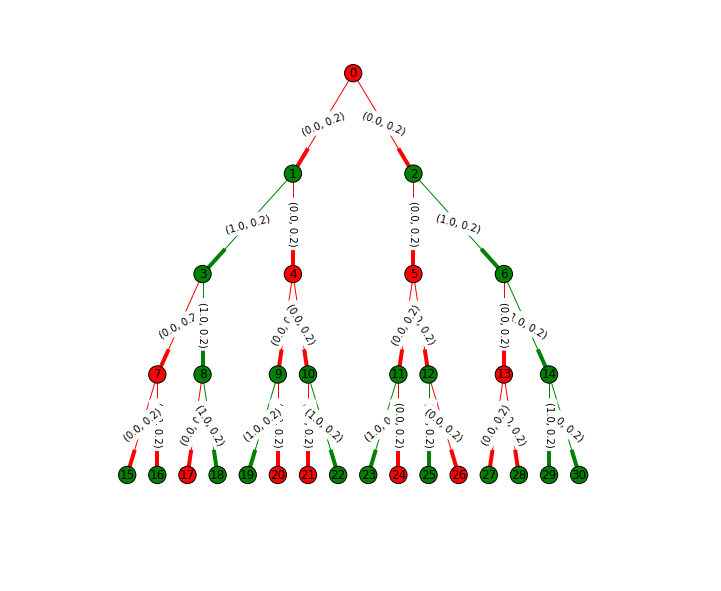

In [7]:
all_iterations = dict()
for it in range(20):
    ## Order can be -1 or 1
    flips = {1:-1, -1:1}
    order = -1
    delta = 0.8 ## The higher the delta the more skeptical we are
    root_node = 0
    bits = dict()
    bits[root_node] = order
    flip_keep = dict()

    for edge in list(nx.bfs_edges(G ,root_node)):
        source_node = edge[0]
        target_node = edge[1]
        source_bit = bits[source_node]
        #print "##", edge, source_bit
        current_alpha = G[source_node][target_node]['alpha']
        current_info = G[source_node][target_node]['H']
        processed_info = current_alpha + current_info * source_bit
        #print "processed_info", processed_info, "delta", delta
        if processed_info >= delta:
            ## Keeping
            #print "Keeping"
            processed_bit = source_bit
            flip_keep[(source_node,target_node)] = 'keep'
        else:
            ## Flipping
            #print "Flipping"
            processed_bit = flips[source_bit]
            flip_keep[(source_node,target_node)] = 'flip'
        bits[target_node] = processed_bit

    ## We are counting the overall outcome in the whole system
    ## We need the good outcomes to be greater than bad outcomes to 
    ## make it a collective good outcome
    collective_outcome = ""

    ##  If its a good outcome:
    ##       if I followed my supervisors order, I trust him more
    ##       if I flipped my supervisors order, I trust him less
    ## If its a bad outcome:
    ##       if I followed my supervisors order, I trust him less
    ##       if I flipped my supervisors order, I trust him more 
    ##           (you can think of it this way, it is a bad outcome
    ##           and I did not abide by his order, and based on my local 
    ##           knowledge, I feel I should have gone with my supervisors
    ##           order)
    if Counter(bits.values())[1] > Counter(bits.values())[-1]:
        collective_outcome = "good"
        for edge, current_alpha in nx.get_edge_attributes(G, 'alpha').items():
            if flip_keep[edge] == "keep":
            ## It was a good outcome and I listened to my supervisor, so I feel he is a person I can trust more
                #print edge, current_alpha
                new_alpha = current_alpha + sample_change_in_alpha(mean_change_in_alpha, sd_change_in_alpha)
                if new_alpha > 1:
                    new_alpha = 1
                elif new_alpha < 0:
                    new_alpha = 0
                G[edge[0]][edge[1]]['alpha'] = new_alpha
            else:
            ## It was a good outcome and I did not listen to my supervisor, so I feel he is a person I should trust less, because by not listening to him, I feel that I contributed to the good outcome
                #print edge, current_alpha
                new_alpha = current_alpha - sample_change_in_alpha(mean_change_in_alpha, sd_change_in_alpha)
                if new_alpha > 1:
                    new_alpha = 1
                elif new_alpha < 0:
                    new_alpha = 0
                G[edge[0]][edge[1]]['alpha'] = new_alpha
    else:
        collective_outcome = "bad"
        for edge, current_alpha in nx.get_edge_attributes(G, 'alpha').items():
            if flip_keep[edge] == "keep":
            ## It was a bad outcome and I listened to my supervisor, and by listening to him I contributed to the disaster, so I feel he is a person I should trust less
                #print edge, current_alpha
                new_alpha = current_alpha - sample_change_in_alpha(mean_change_in_alpha, sd_change_in_alpha)
                if new_alpha > 1:
                    new_alpha = 1
                elif new_alpha < 0:
                    new_alpha = 0
                G[edge[0]][edge[1]]['alpha'] = new_alpha
            else:
            ## It was a bad outcome and I did not listen to my supervisor, so I feel by listening to him I could have averted the disaster, so I feel I should listen to him/ trust him more.
                #print edge, current_alpha
                new_alpha = current_alpha + sample_change_in_alpha(mean_change_in_alpha, sd_change_in_alpha)
                if new_alpha > 1:
                    new_alpha = 1
                elif new_alpha < 0:
                    new_alpha = 0
                G[edge[0]][edge[1]]['alpha'] = new_alpha


    all_iterations[it] = dict()
    all_iterations[it]['collective_outcome'] = collective_outcome
    #print collective_outcome
    all_iterations[it]['flip_keep'] = flip_keep
    #print Counter(flip_keep.values())
    all_iterations[it]['bits'] = bits
    #print Counter(bits.values())

    #print nx.get_edge_attributes(G, 'alpha')
    all_iterations[it]['alpha'] = nx.get_edge_attributes(G, 'alpha')
    
    labels = dict()
    alphas = nx.get_edge_attributes(G, 'alpha')
    Hs = nx.get_edge_attributes(G, 'H')
    for key in G.edges():
        #print key
        current_alpha = round(alphas[key], 1)
        current_H = round(Hs[key], 1)
        labels[key] = (current_alpha, current_H)
    # print labels

    plt.figure(figsize=(12,10))
    pos=nx.nx_pydot.graphviz_layout(G,prog='dot')
    nx.draw_networkx_edge_labels(G,pos=nx.nx_pydot.graphviz_layout(G,prog='dot'), edge_labels = labels)
    color_map_node = {1:'g', -1:'r'} 
    color_map_edge = {"keep":'g', "flip":'r'} 
    # colors = [G[u][v]['color'] for u,v in edges]
    nx.draw(G,pos, node_color=[color_map_node[bits[node]] for node in G],  edge_color=[color_map_edge[flip_keep[edge]] for edge in G.edges()],with_labels=True,arrows=True)

In [8]:
output = list()
looking_for = "collective_outcome"
for i in range(len(all_iterations.keys())):
    output.append(all_iterations[i][looking_for])
print output

['bad', 'bad', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good']


In [27]:
all_iterations[2]['alpha']

{(0, 1): 0.55020391384241951,
 (0, 2): 0.55226480021766833,
 (1, 3): 0.65278820078968258,
 (1, 4): 0.55005850793469935,
 (2, 5): 0.54910884711012498,
 (2, 6): 0.64890794300259713,
 (3, 7): 0.55064647478048911,
 (3, 8): 0.6542038464427451,
 (4, 9): 0.54864423234430759,
 (4, 10): 0.55201954808693665,
 (5, 11): 0.54849392287816356,
 (5, 12): 0.54737684447038681,
 (6, 13): 0.54847557003063718,
 (6, 14): 0.6480149763076255,
 (7, 15): 0.54728627528481466,
 (7, 16): 0.54675244350854835,
 (8, 17): 0.54743034686787329,
 (8, 18): 0.6541911423053689,
 (9, 19): 0.65086376851489169,
 (9, 20): 0.54866270571786768,
 (10, 21): 0.54877158733174969,
 (10, 22): 0.65168184946403485,
 (11, 23): 0.64981623692061208,
 (11, 24): 0.54686411266958856,
 (12, 25): 0.65180384306479044,
 (12, 26): 0.54816130612201497,
 (13, 27): 0.54917734046633215,
 (13, 28): 0.55520693685112443,
 (14, 29): 0.65067040017366429,
 (14, 30): 0.65269939742109739}

In [10]:
output = list()
looking_for = "bits"
for i in range(len(all_iterations.keys())):
    counter = (Counter(all_iterations[i][looking_for].values()))
    ratio = counter[1]/ float( sum(counter.values()))
    output.append(round(ratio,3))
print output

[0.323, 0.323, 0.677, 0.677, 0.677, 0.677, 0.677, 0.677, 0.677, 0.677, 0.677, 0.677, 0.677, 0.677, 0.677, 0.677, 0.677, 0.677, 0.677, 0.677]


In [11]:
print flip_keep

{(1, 3): 'keep', (14, 30): 'keep', (11, 23): 'keep', (10, 21): 'flip', (7, 16): 'flip', (11, 24): 'flip', (3, 7): 'flip', (2, 5): 'flip', (6, 14): 'keep', (4, 9): 'flip', (7, 15): 'flip', (5, 12): 'flip', (10, 22): 'keep', (4, 10): 'flip', (2, 6): 'keep', (9, 20): 'flip', (5, 11): 'flip', (12, 25): 'keep', (1, 4): 'flip', (13, 28): 'flip', (8, 17): 'flip', (14, 29): 'keep', (0, 1): 'flip', (12, 26): 'flip', (13, 27): 'flip', (3, 8): 'keep', (8, 18): 'keep', (6, 13): 'flip', (9, 19): 'keep', (0, 2): 'flip'}


In [12]:
print Counter(flip_keep.values())

Counter({'flip': 19, 'keep': 11})


In [13]:
Counter(bits.values())

Counter({-1: 10, 1: 21})

In [14]:
labels = dict()
alphas = nx.get_edge_attributes(G, 'alpha')
Hs = nx.get_edge_attributes(G, 'H')
for key in G.edges():
    print key
    current_alpha = round(alphas[key], 1)
    current_H = round(Hs[key], 1)
    labels[key] = (current_alpha, current_H)
print labels

(0, 1)
(0, 2)
(1, 3)
(1, 4)
(2, 5)
(2, 6)
(3, 8)
(3, 7)
(4, 9)
(4, 10)
(5, 11)
(5, 12)
(6, 13)
(6, 14)
(7, 16)
(7, 15)
(8, 17)
(8, 18)
(9, 19)
(9, 20)
(10, 21)
(10, 22)
(11, 24)
(11, 23)
(12, 25)
(12, 26)
(13, 27)
(13, 28)
(14, 29)
(14, 30)
{(1, 3): (1.0, 0.2), (14, 30): (1.0, 0.2), (11, 23): (1.0, 0.2), (10, 21): (0.0, 0.2), (7, 16): (0.0, 0.2), (11, 24): (0.0, 0.2), (3, 7): (0.0, 0.2), (2, 5): (0.0, 0.2), (6, 14): (1.0, 0.2), (4, 9): (0.0, 0.2), (7, 15): (0.0, 0.2), (5, 12): (0.0, 0.2), (10, 22): (1.0, 0.2), (4, 10): (0.0, 0.2), (2, 6): (1.0, 0.2), (9, 20): (0.0, 0.2), (5, 11): (0.0, 0.2), (12, 25): (1.0, 0.2), (1, 4): (0.0, 0.2), (13, 28): (0.0, 0.2), (8, 17): (0.0, 0.2), (14, 29): (1.0, 0.2), (0, 1): (0.0, 0.2), (12, 26): (0.0, 0.2), (13, 27): (0.0, 0.2), (3, 8): (1.0, 0.2), (8, 18): (1.0, 0.2), (6, 13): (0.0, 0.2), (9, 19): (1.0, 0.2), (0, 2): (0.0, 0.2)}


In [15]:
labels = dict()
alphas = nx.get_edge_attributes(G, 'alpha')
Hs = nx.get_edge_attributes(G, 'H')
for key in G.edges():
    #print key
    current_alpha = round(alphas[key], 1)
    current_H = round(Hs[key], 1)
    labels[key] = (current_alpha, current_H)
# print labels

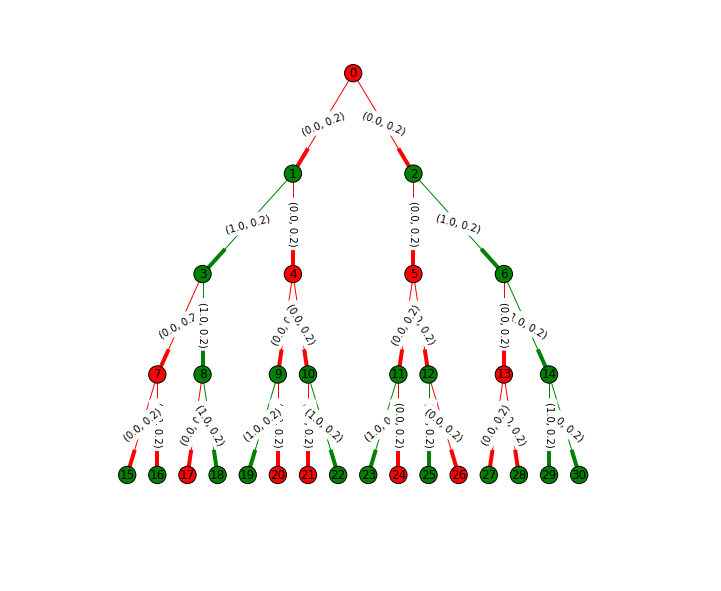

In [16]:
labels = dict()
alphas = nx.get_edge_attributes(G, 'alpha')
Hs = nx.get_edge_attributes(G, 'H')
for key in G.edges():
    #print key
    current_alpha = round(alphas[key], 1)
    current_H = round(Hs[key], 1)
    labels[key] = (current_alpha, current_H)
# print labels

plt.figure(figsize=(12,10))
pos=nx.nx_pydot.graphviz_layout(G,prog='dot')
nx.draw_networkx_edge_labels(G,pos=nx.nx_pydot.graphviz_layout(G,prog='dot'), edge_labels = labels)
color_map_node = {1:'g', -1:'r'} 
color_map_edge = {"keep":'g', "flip":'r'} 
# colors = [G[u][v]['color'] for u,v in edges]
nx.draw(G,pos, node_color=[color_map_node[bits[node]] for node in G],  edge_color=[color_map_edge[flip_keep[edge]] for edge in G.edges()],with_labels=True,arrows=True)

In [17]:
{(0, 1): (0., 0.9), (1, 3): (0.7, 0.7), (1, 4): (0.7, 0.7), (2, 6): (0.3, 0.6), (2, 5): (0.9, 0.8), (0, 2): (0.5, 0.9)}

{(0, 1): (0.0, 0.9),
 (0, 2): (0.5, 0.9),
 (1, 3): (0.7, 0.7),
 (1, 4): (0.7, 0.7),
 (2, 5): (0.9, 0.8),
 (2, 6): (0.3, 0.6)}